In [3]:
import torch
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Add project root to path
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from result_analysis.load_model import load_model
from eval_utils.rotation_utils import QKRotationWrapper
from utils.quant_utils import ActQuantWrapper, ActQuantizer

print("Current working directory:", os.getcwd())

Current working directory: /home/jaeyongjang/project.local/SpinQuant/result_analysis


In [4]:
# Load Model
print("Loading model...")
model, tokenizer = load_model(
    input_model="../models/llama2-7b",
    load_qmodel_path="../saved_models/llama2-7b/a16w4kv4-vasym.pt",
    optimized_rotation_path="../rotation_llama-2-7b/a16w4kv4-vsym/R.bin",
    w_bits=4,
    a_bits=16,
    k_bits=4,
    v_bits=4,
    k_groupsize=128,
    v_groupsize=128,
    w_clip=True,
    a_asym=True,
    k_asym=True,
    v_asym=True,
    rotate=True
)
model.eval()

2025-12-13 18:25:14,484 - spinquant - INFO - Loading model with args: ['python', '--input_model', '../models/llama2-7b', '--do_train', 'False', '--do_eval', 'True', '--per_device_eval_batch_size', '4', '--model_max_length', '2048', '--fp16', 'True', '--bf16', 'False', '--save_safetensors', 'False', '--w_bits', '4', '--a_bits', '16', '--k_bits', '4', '--v_bits', '4', '--k_groupsize', '128', '--v_groupsize', '128', '--w_clip', '--a_asym', '--k_asym', '--v_asym', '--rotate', '--load_qmodel_path', '../saved_models/llama2-7b/a16w4kv4-vasym.pt', '--optimized_rotation_path', '../rotation_llama-2-7b/a16w4kv4-vsym/R.bin']
2025-12-13 18:25:14,562 - spinquant - INFO - ------- ARGS ----------
2025-12-13 18:25:14,564 - spinquant - INFO - -----model args-----
2025-12-13 18:25:14,565 - spinquant - INFO - ModelArguments(input_model='../models/llama2-7b', output_rotation_path='test-output', optimized_rotation_path='../rotation_llama-2-7b/a16w4kv4-vsym/R.bin', access_token=None)
2025-12-13 18:25:14,566 

Loading model...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/jaeyongjang/.conda/envs/spinquant/lib/python3.10/site-packages/transformers/modeling_utils.py:4713: FutureWarning: `_is_quantized_training_enabled` is going to be deprecated in transformers 4.39.0. Please use `model.hf_quantizer.is_trainable` instead
  warnings.warn(


Load quantized model from  ../saved_models/llama2-7b/a16w4kv4-vasym.pt


2025-12-13 18:25:29,240 - spinquant - INFO - Model PTQ completed LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (k_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (v_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 4 (Asymmetric Per-Token)
            (module): Linear(in_features=409

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (k_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 16
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQuantizer()
            (out_quantizer): ActQuantizer()
          )
          (v_proj): ActQuantWrapper(
            Input Quantizer Bits: 16
            Output Quantizer Bits: 4 (Asymmetric Per-Token)
            (module): Linear(in_features=4096, out_features=4096, bias=False)
            (quantizer): ActQua

In [7]:
# Load Quantizers for Weights
# We need to load the save_dict manually to get w_quantizers
load_qmodel_path = "../saved_models/llama2-7b/a16w4kv4-vasym.pt"
print(f"Loading quantizers from {load_qmodel_path}...")
save_dict = torch.load(load_qmodel_path, map_location="cpu", weights_only=False)
w_quantizers = save_dict.get("w_quantizers", {})

if not w_quantizers:
    print("Warning: No w_quantizers found in checkpoint. Weight analysis might be incorrect if weights are not fake-quantized.")
else:
    print(f"Found {len(w_quantizers)} weight quantizers.")

Loading quantizers from ../saved_models/llama2-7b/a16w4kv4-vasym.pt...
Found 224 weight quantizers.


Analyzing Layer 0 Weights (Int4) - Row-wise...
--- Analyzing self_attn.q_proj ---
Shape: torch.Size([4096, 4096])
Value range: -8 to 7


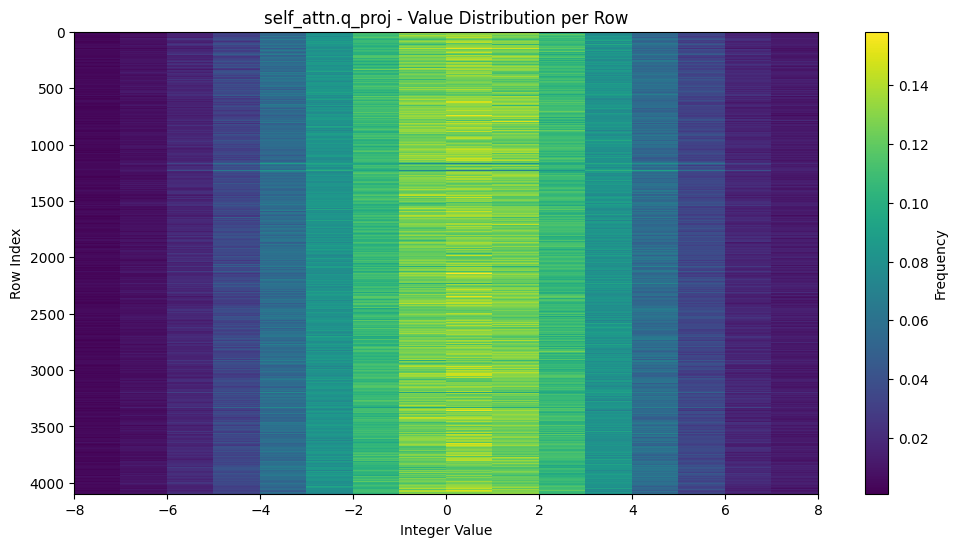

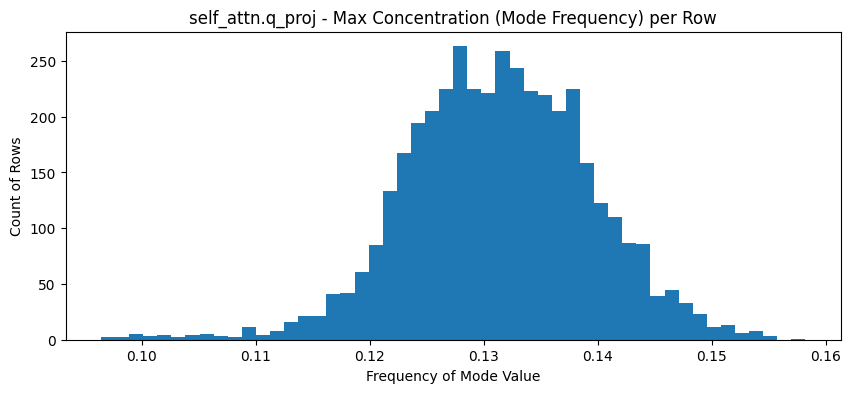

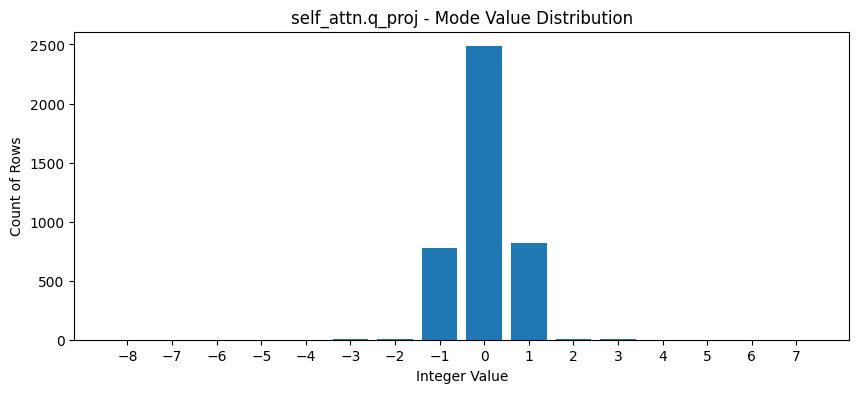

--- Analyzing self_attn.k_proj ---
Shape: torch.Size([4096, 4096])
Value range: -8 to 7


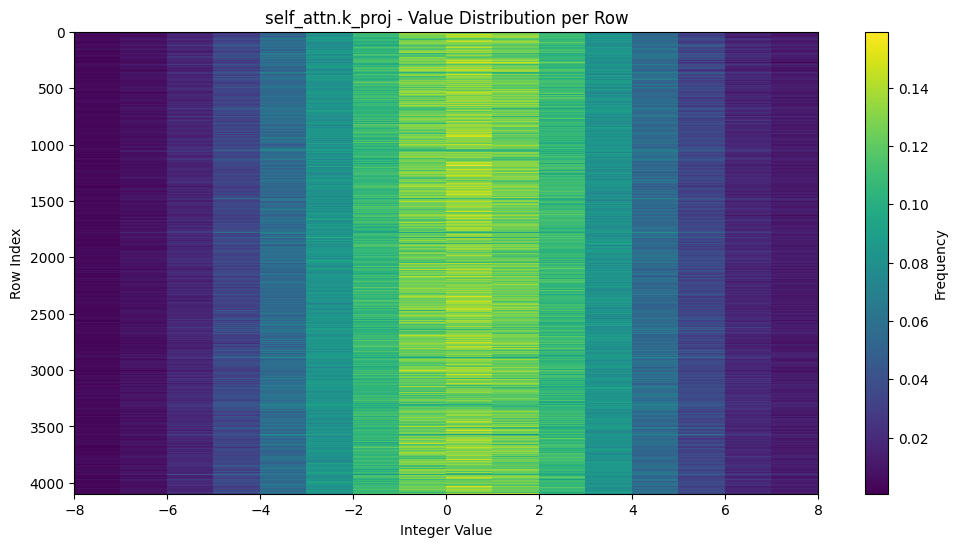

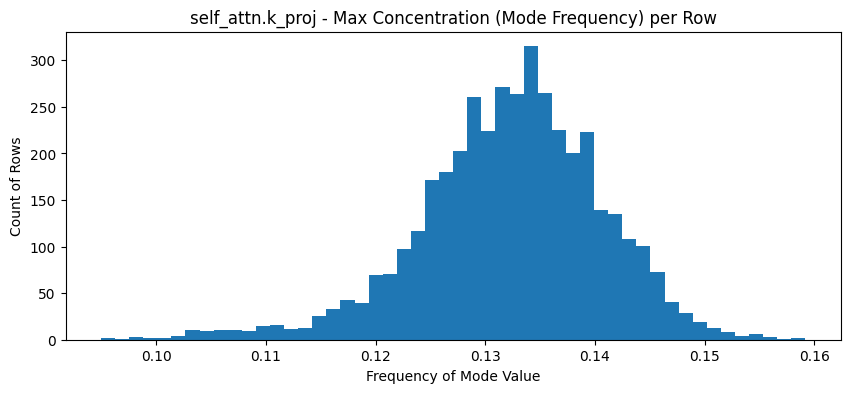

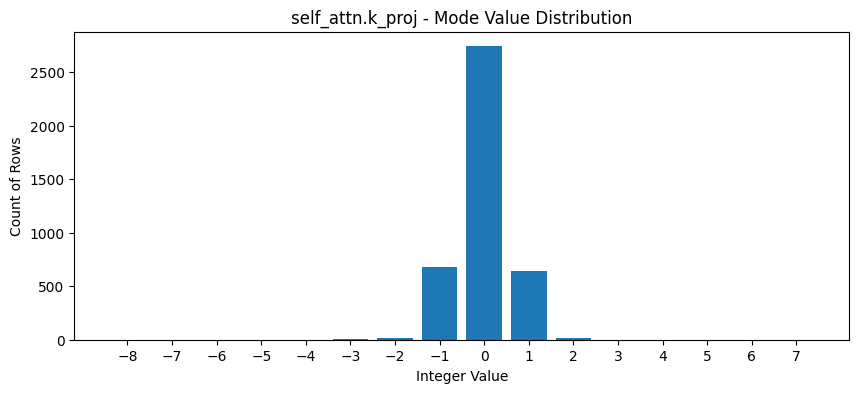

--- Analyzing self_attn.v_proj ---
Shape: torch.Size([4096, 4096])
Value range: -8 to 7


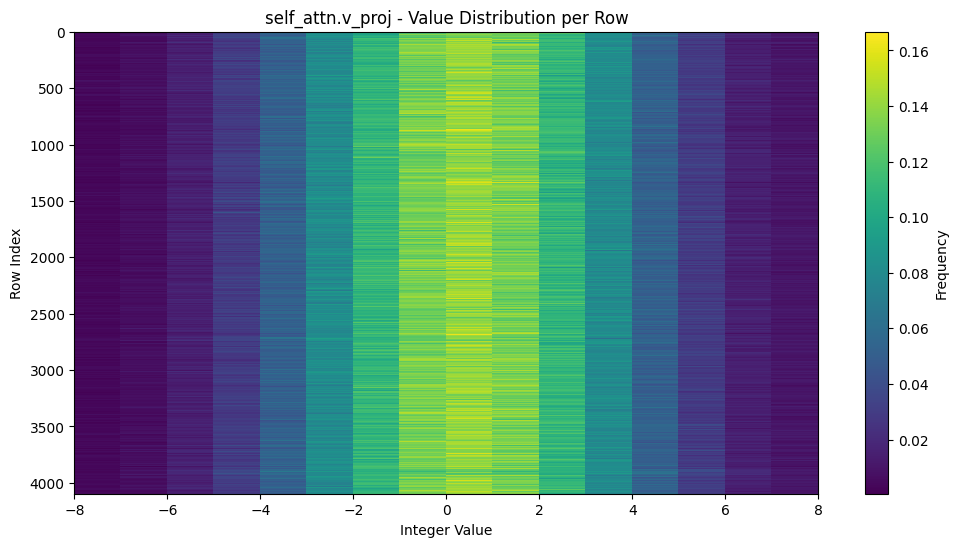

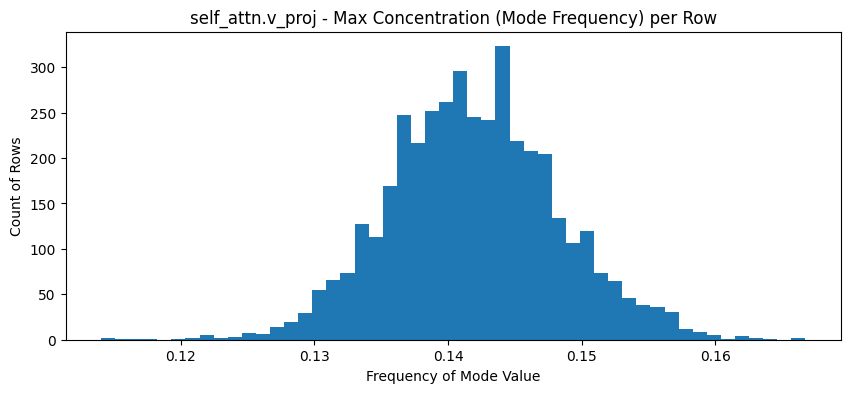

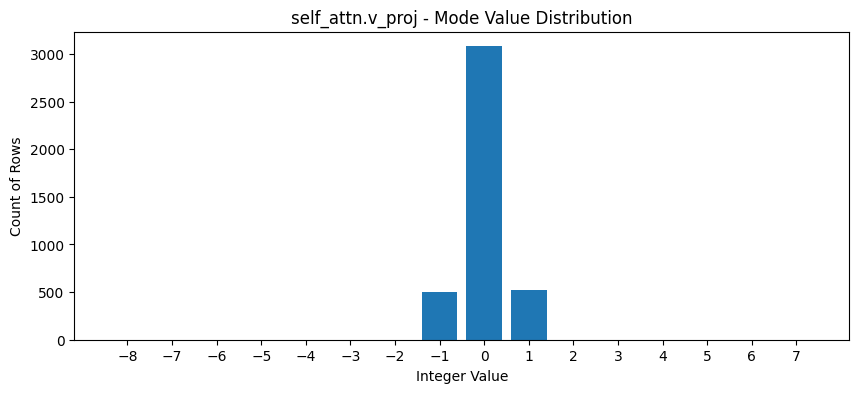

--- Analyzing self_attn.o_proj ---
Shape: torch.Size([4096, 4096])
Value range: -8 to 7


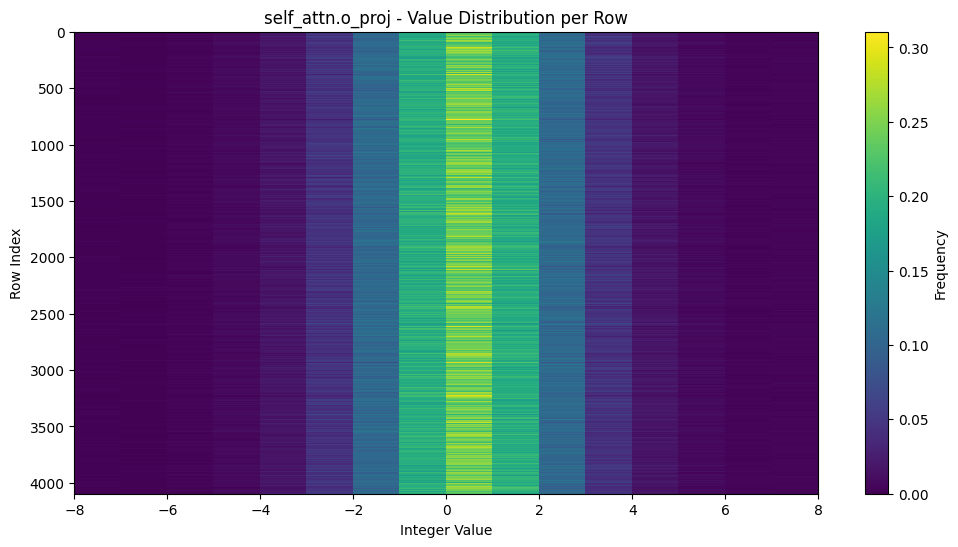

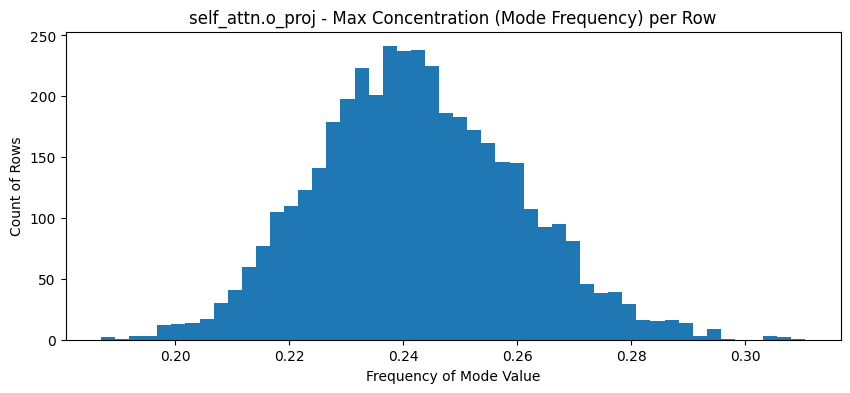

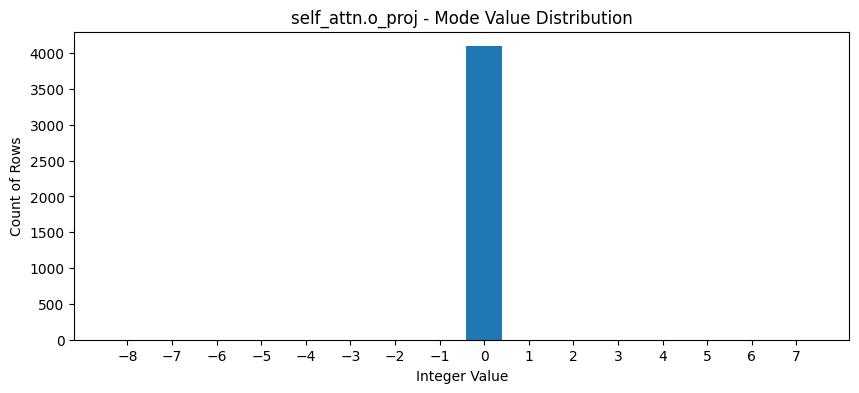

--- Analyzing mlp.gate_proj ---
Shape: torch.Size([11008, 4096])
Value range: -8 to 7


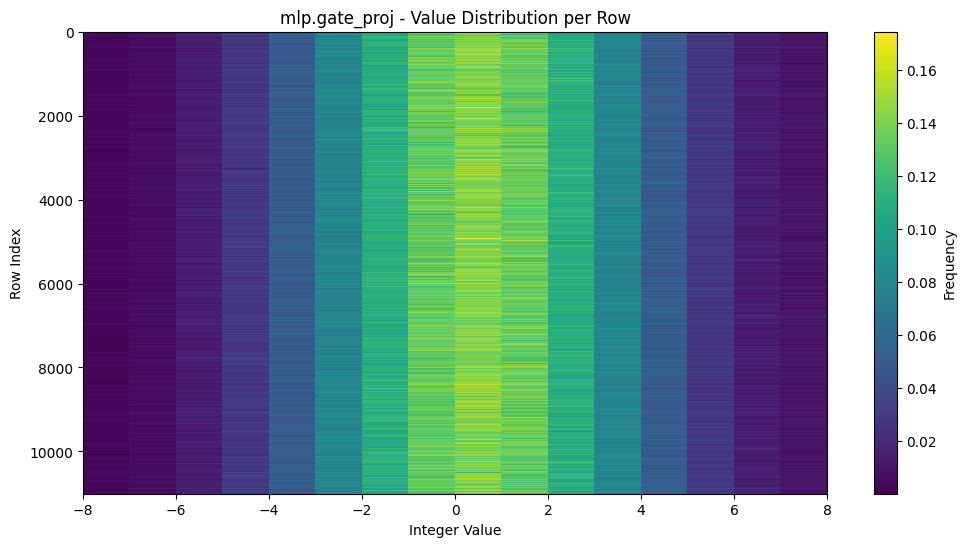

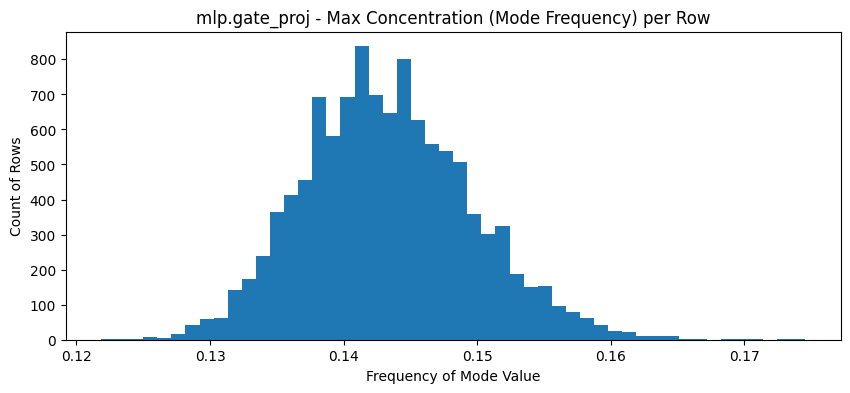

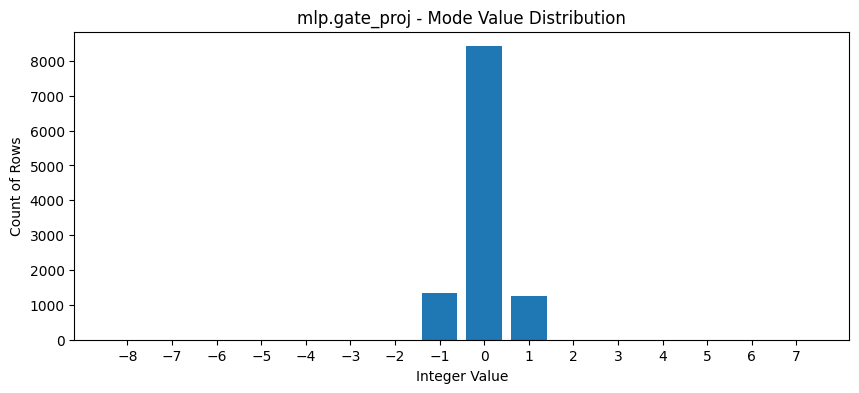

--- Analyzing mlp.up_proj ---
Shape: torch.Size([11008, 4096])
Value range: -8 to 7


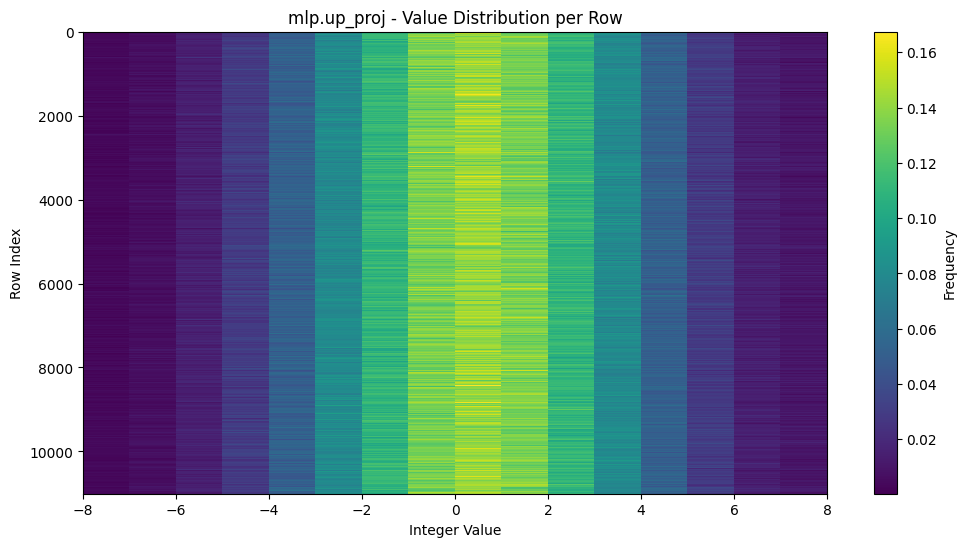

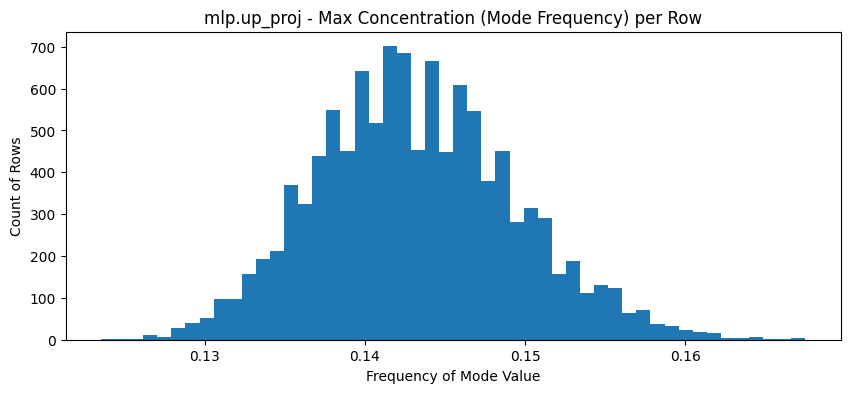

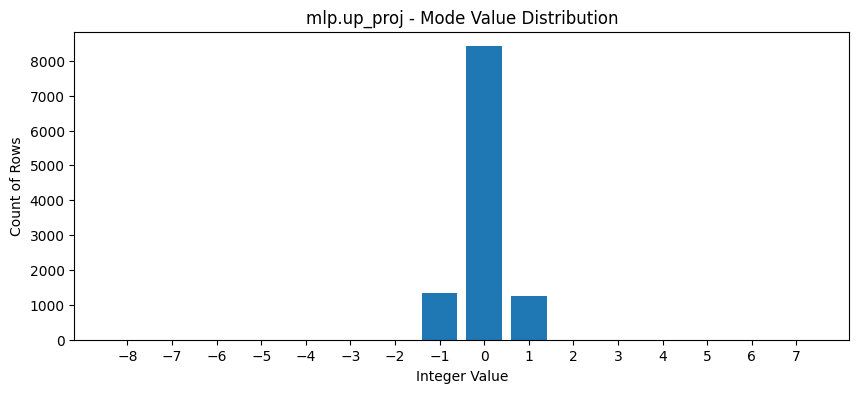

--- Analyzing mlp.down_proj ---
Shape: torch.Size([4096, 11008])
Value range: -8 to 7


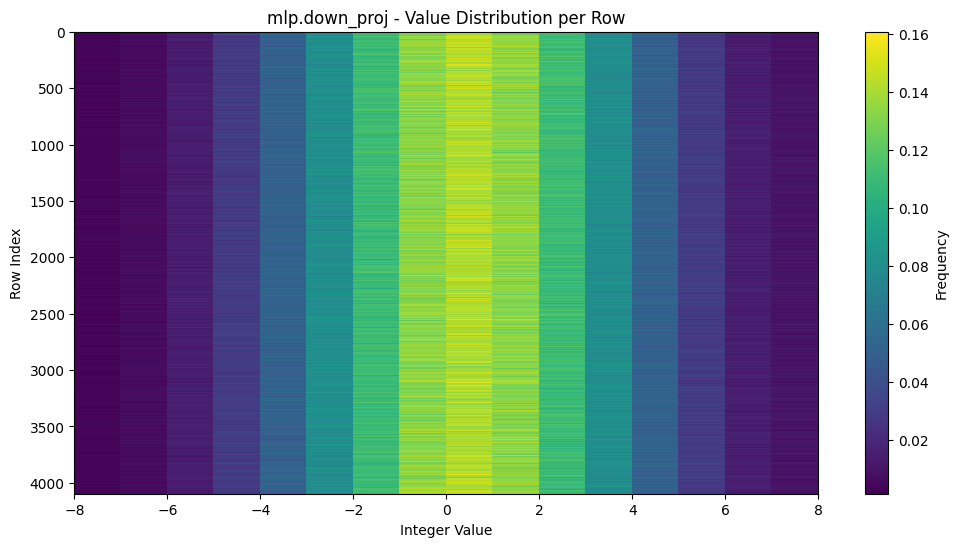

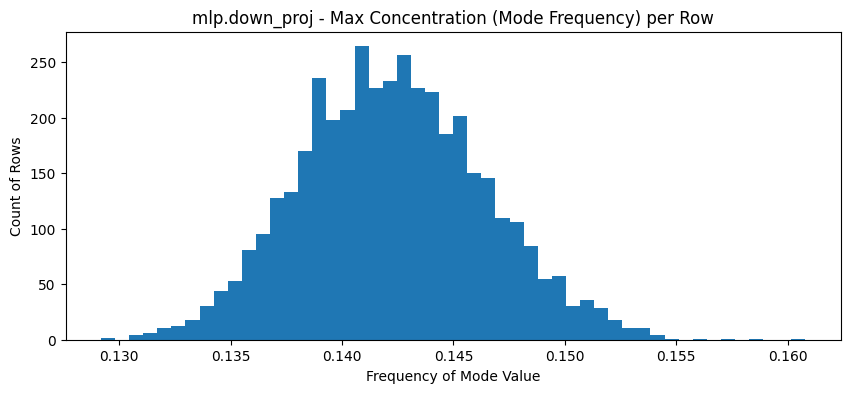

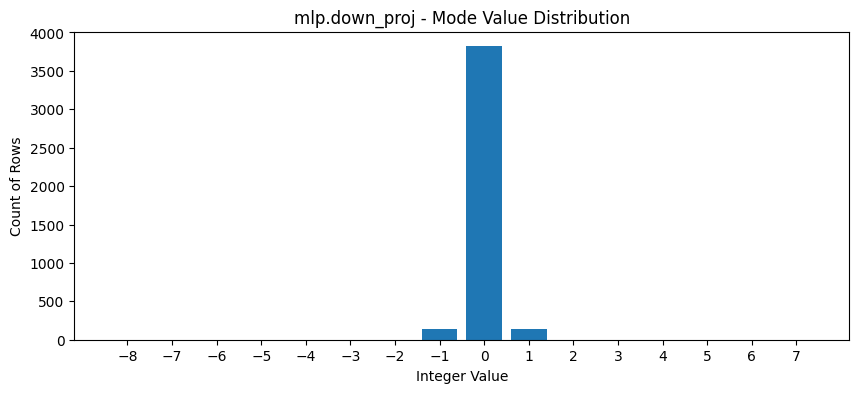

In [13]:
# Analyze Weights (Int4) for Layer 0 - Row-wise Analysis
print("Analyzing Layer 0 Weights (Int4) - Row-wise...")

import seaborn as sns

# Iterate over modules in layer 0
layer0 = model.model.layers[0]

# Helper to process linear layers
def get_int_weight(name, module):
    # Find corresponding quantizer
    # The keys in w_quantizers are like 'model.layers.0.self_attn.q_proj'
    full_name = f"model.layers.0.{name}.module"
    
    if full_name in w_quantizers:
        quantizer = w_quantizers[full_name]
        weight = module.weight.data.to(quantizer.scale.device) # Fake quantized weight
        
        scale = quantizer.scale.to(weight.device)
        zero = quantizer.zero.to(weight.device)
        
        # Avoid division by zero
        scale = scale + 1e-9
        
        w_int = (weight / scale) + zero
        w_int = torch.round(w_int)
        return w_int.cpu()
    else:
        print(f"Quantizer not found for {full_name}")
        return None

targets = {
    "self_attn.q_proj": layer0.self_attn.q_proj,
    "self_attn.k_proj": layer0.self_attn.k_proj,
    "self_attn.v_proj": layer0.self_attn.v_proj,
    "self_attn.o_proj": layer0.self_attn.o_proj,
    "mlp.gate_proj": layer0.mlp.gate_proj,
    "mlp.up_proj": layer0.mlp.up_proj,
    "mlp.down_proj": layer0.mlp.down_proj
}

for name, module in targets.items():
    print(f"--- Analyzing {name} ---")
    w_int = get_int_weight(name, module)
    if w_int is None:
        continue
    
    # w_int shape: [out_features, in_features] -> [rows, cols]
    rows, cols = w_int.shape
    print(f"Shape: {w_int.shape}")
    
    # 1. Value Counts per Row
    min_val = int(w_int.min().item())
    max_val = int(w_int.max().item())
    val_range = max_val - min_val + 1
    print(f"Value range: {min_val} to {max_val}")
    
    # Shift values to 0-based index
    w_shifted = (w_int - min_val).long()
    
    # Vectorized bincount for all rows
    row_indices = torch.arange(rows).unsqueeze(1).expand(rows, cols).reshape(-1)
    flat_values = w_shifted.reshape(-1)
    
    flat_indices = row_indices * val_range + flat_values
    counts = torch.bincount(flat_indices, minlength=rows*val_range).reshape(rows, val_range)
    
    # Convert to numpy for plotting
    counts_np = counts.numpy()
    
    # Normalize to get probabilities/percentages
    probs_np = counts_np / cols
    
    # 2. Heatmap of Value Distribution
    plt.figure(figsize=(12, 6))
    # Plot heatmap
    # X-axis: Integer Values
    # Y-axis: Row Index
    plt.imshow(probs_np, aspect='auto', cmap='viridis', interpolation='nearest', extent=[min_val, max_val+1, rows, 0])
    plt.colorbar(label='Frequency')
    plt.title(f"{name} - Value Distribution per Row")
    plt.xlabel(f"Integer Value")
    plt.ylabel("Row Index")
    plt.show()
    
    # 3. Concentration Analysis (Max Probability per Row)
    max_probs = np.max(probs_np, axis=1)
    
    plt.figure(figsize=(10, 4))
    plt.hist(max_probs, bins=50)
    plt.title(f"{name} - Max Concentration (Mode Frequency) per Row")
    plt.xlabel("Frequency of Mode Value")
    plt.ylabel("Count of Rows")
    plt.show()
    
    # 4. Mode Value Distribution
    mode_indices = np.argmax(probs_np, axis=1)
    mode_values = mode_indices + min_val
    
    plt.figure(figsize=(10, 4))
    plt.hist(mode_values, bins=np.arange(min_val, max_val+2)-0.5, rwidth=0.8)
    plt.title(f"{name} - Mode Value Distribution")
    plt.xlabel("Integer Value")
    plt.ylabel("Count of Rows")
    plt.xticks(np.arange(min_val, max_val+1))
    plt.show()

Analyzing Layer 0 KV Cache (Int4)...


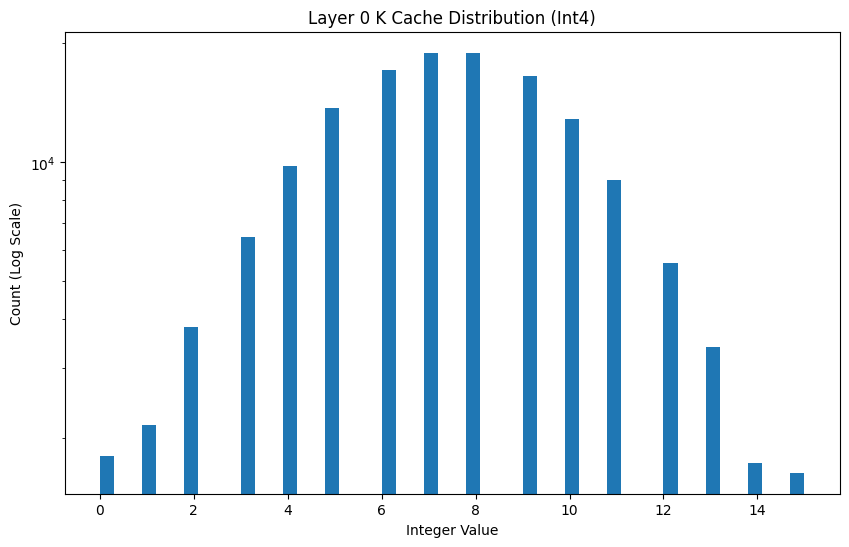

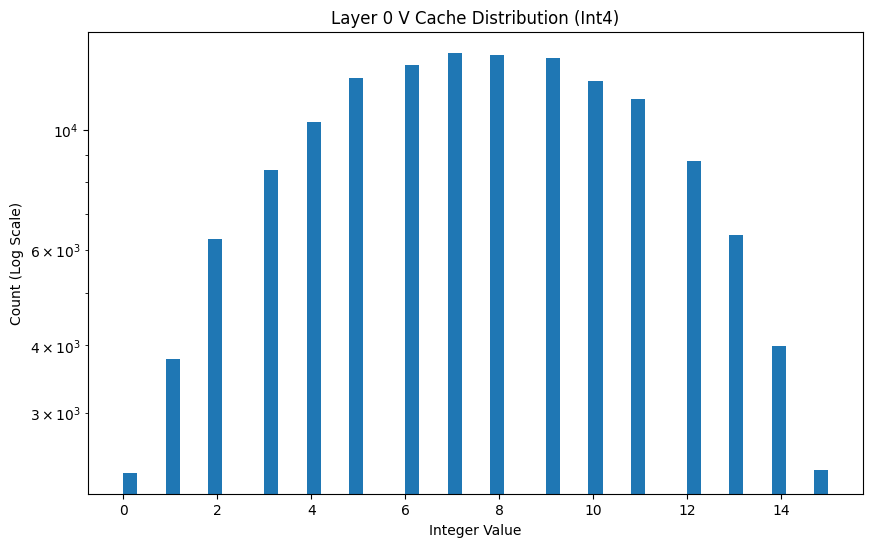

In [9]:
# Analyze KV Cache (Int4) for Layer 0
print("Analyzing Layer 0 KV Cache (Int4)...")

k_int_values = []
v_int_values = []

# Hooks
def k_quant_hook(module, input, output):
    # input is a tuple (x,), output is fake-quantized x
    # We want to quantize x to int
    # module is ActQuantizer
    x = input[0]
    # quantize returns (q, scale, zero) or (q, scale)
    res = module.quantize(x)
    q = res[0]
    k_int_values.append(q.detach().cpu().flatten().numpy())

def v_quant_hook(module, input, output):
    # module is ActQuantizer (out_quantizer of v_proj)
    # But wait, ActQuantWrapper calls out_quantizer(x)
    # So input to out_quantizer is x.
    x = input[0]
    res = module.quantize(x)
    q = res[0]
    v_int_values.append(q.detach().cpu().flatten().numpy())

# Register hooks
# K: apply_rotary_pos_emb_qk_rotation_wrapper.k_quantizer
k_quantizer = layer0.self_attn.apply_rotary_pos_emb_qk_rotation_wrapper.k_quantizer
h1 = k_quantizer.register_forward_hook(k_quant_hook)

# V: v_proj.out_quantizer
v_quantizer = layer0.self_attn.v_proj.out_quantizer
h2 = v_quantizer.register_forward_hook(v_quant_hook)

# Run Forward
text = "Hello, this is a test sentence to analyze the distribution of weights and kv cache. " * 2
input_ids = tokenizer(text, return_tensors="pt").input_ids.to(model.device)

with torch.no_grad():
    model(input_ids)
    
h1.remove()
h2.remove()

# Plot K
if k_int_values:
    all_k = np.concatenate(k_int_values)
    plt.figure(figsize=(10, 6))
    plt.hist(all_k, bins=50, log=True)
    plt.title("Layer 0 K Cache Distribution (Int4)")
    plt.xlabel("Integer Value")
    plt.ylabel("Count (Log Scale)")
    plt.show()
else:
    print("No K cache captured.")

# Plot V
if v_int_values:
    all_v = np.concatenate(v_int_values)
    plt.figure(figsize=(10, 6))
    plt.hist(all_v, bins=50, log=True)
    plt.title("Layer 0 V Cache Distribution (Int4)")
    plt.xlabel("Integer Value")
    plt.ylabel("Count (Log Scale)")
    plt.show()
else:
    print("No V cache captured.")